# Challenge Large Scale Machine Learning


# 0. Introduction


### Authors: 
Pavlo Mozharovskyi (pavlo.mozharovskyi@telecom-paris.fr), Stephan Clémençon, Jayant Sen Gupta


## Functional anomaly detection

**Anomaly detection** (or **outlier detection**) comprises the **machine learning** methods aimed at identification of observations that exhibit suspicious behaviour and are very likely to cause a problem. In the **unsupervised learning** framework, no label indicating whether a training observation is anomalous or not is available. Hence, anomalies should be identified in an automatic way by learning the *normal* behavior, that of the vast majority of the observations, and considering those differing significantly from it as *abnormal*. Logically, anomalies are rare in the data and thus fall in *low density* regions: anomaly detection thus boils down to identifying the *tail* of the distribution.

With the ubiquitous deployment of sensors monitoring nearly continuously the health of complex infrastructures, **anomaly detection** can now rely on measurements sampled at a very high frequency, providing a very rich representation of the phenomenon under surveillance. In order to exploit fully the collected information, the observations cannot be treated as multivariate data anymore and a functional analysis approach is required.

A (very) short list of **literature** regarding functional anomaly detection can include:
 - J.O. Ramsay, Silverman, B.W. (2005): Functional Data Analysis. Springer-Verlag, New-York.
 - Ferraty, F., Vieu, P. (2006): Nonparametric Functional Data Analysis: Theory and Practice. Springer Science & Business Media.
 - Chandola, V., Banerjee, A., Kumar, V. (2009): Anomaly detection: A survey. ACM Computing Surveys (CSUR) 41(3), 1-58.
 - Hubert, M., Rousseeuw, P.J., Segaert, P. (2015): Multivariate functional outlier detection. Statistical Methods & Applications 24(2), 177-202.
 - Wang, J.L., Chiou, J.M., Müller, H.G. (2016): Functional data analysis. Annual Review of Statistics and Its Application 3, 257-295.

## The properties of the dataset

The data set is provided by the Airbus and consistst of the measures of the accelerometer of helicopters during  1 minute at frequency 1024 Hertz, which yields time series measured at in total 60 * 1024 = 61440 equidistant time points.

### Training data: 

The training set consists of one file, **airbus_train.csv**.

File **airbus_train.csv** contains one observation per row, each observation having 61440 entries, measures with equivalent time distance of 1 / 1024 seconds.

There are in total 1677 training observations.

Training data, input (file **airbus_train.csv**): https://partage.imt.fr/index.php/s/zqrRggLBY8GRc9i

### Test data:

The training set consists of one file, **airbus_test.csv**, which has the same structure as file **airbus_train.csv**.

There are in total 2511 test observations.

Training data, output (file airbus_test.csv): https://partage.imt.fr/index.php/s/WpiqcjMq8ymg8zA

### Remark:

The task of the **unsupervised anomaly detection** is difficult, in the sense that, strictly speaking, your only feedback will be your score calculated by the submission website.

## The performance criterion

You should submit a file that contains in each row anomaly score for the observation in the corresponding row of the file **airbus_test.csv**. For a sample submission please see the codes below. Please note, that your score should provide ordering which allows to identify anomalies, i.e. the higher the value of the score, the **more abnormal** the observation should be considered.

The performance criterion is the **Area Under the Receiver Operating Characteristic** (AUC), see also:
https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve

## Notes


**Data Exploration**
* Etudier les statistiques descriptives du fichier de soumissions. Comment sont réparties les variablse vs le score obtenu.
* Le 690 et 691 sont pareils sauf une anomalie non ?
* Afficher les features des deux jeux de données (min, max, mean, var, etc.)
* Réussir à afficher des clusters


**Data Augmentation**
* Les colonnes ont toutes la même signification ! Faire des études avec l'ordre des colonnes mélangés (data augmentation ?) et d'autres avec les colonnes normalement et un traitement qui prend en compte la composante temporelle.
* Concaténer xtrain et xtest, voir entraîner le modèle que sur xtest.
* Déterminer des types de graphes, en fonction de la forme de la courbe, et appliquer un modèle par type.
* Normaliser les time series
* Data augmentation: séparer chaque time series en 3. Appliquer le modèle, puis recoller les 3 morceaux et additionner (ou moyenner) le score_samples à la fin.

**Data preparation**
* Afficher la PCA sur des graphes, 2 valeurs propres à la fois
* Retirer de xtrain les outliers ? ou au contraire, faire de la data augmentation sur ces outliers ? ou faire des clusters à partir de xtrain, puis les mêmes clusters sur xtest et appliquer un algo sur chaque cluster
* Chercher les outliers dans xtrain (avec LOF novelty = False), les virer de xtrain, puis entrainer le modèle final dessus
* Essayer la SparsePCA et d'autres decompositions adaptées aux time series
* Rajouter une colonne cluster, qui indique dans quel cluster est la courbe. Les clusters sont déterminés par un algo (comme t-SNE), il pourrait y avoir 4-5 clusters, en fonction de la forme de la courbe. Il peut y avoir un % d'appartenance à chaque cluster.

**Modèles**
* Isolation forest
* Stacking (en faisant la somme, la moyenne, le **max**)
* Compter le nombre de pixels bleu vs blanc sur les images des time series et calculer un score à partir de ça (peut être normaliser avant de générer les images)

**Autres**
* VAE 2020.pdf
* Essayer avec différents RANDOM_STATE


**DONE**
* Exporter les courbes temporelles des times series en images et utiliser un algo de détection d'anomalies dans des images.
* Data transformation: Générer des features explicatives (stats: mean, valeurs max, min, percentiles, etc., forme de courbe (à calculer) et entrainer un modèle que sur ces features
* Stationnariser par moyenne mobile
* Concatenate xtrain and xtrain_feat
* Fitter le modèle avec seulement les 100 premières lignes de xtrain

**Aujourd'hui**
* OneClassSVM
* Stacking
* Slice
* Virer les outliers de xtrain
* Afficher toutes les courbes de xtrain et xtest après les avoir passées à la moyenne mobile

**Demain**
* Tester plus de méthodes de réductions de données (sparse PCA, etc.) et de modèles (isolation forest, etc.). Tester un réseau de neurones sur les images ? (plus tad)
* A la fin, il faudra qu'on arrive à distinguer des types d'anomalies (plages de valeurs incohérentes, variations dans la forme, etc.) et à appliquer un préprocessing et un modèle différent à chacun, puis stacking 

## Imports

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from scipy.stats import describe
from scipy.stats import rankdata

In [0]:
ROOT = "drive/My Drive/Colab Notebooks/Data Challenge 2/"
RANDOM_STATE = 261

In [8]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# 1. Data loading

In [0]:
%%time

xtrain = np.loadtxt(ROOT + 'data/airbus_train.csv', delimiter= ' ')
print("Train:", xtrain.shape)
xtest = np.loadtxt(ROOT + 'data/airbus_test.csv', delimiter= ' ')
print("Test:", xtest.shape)

# 2. Data exploration

In [0]:
# Plot first 614 time points for first 100 observations
plt.figure(figsize=(16,8))
plt.plot(xtrain[0,:])
plt.show()

NameError: ignored

<Figure size 1152x576 with 0 Axes>

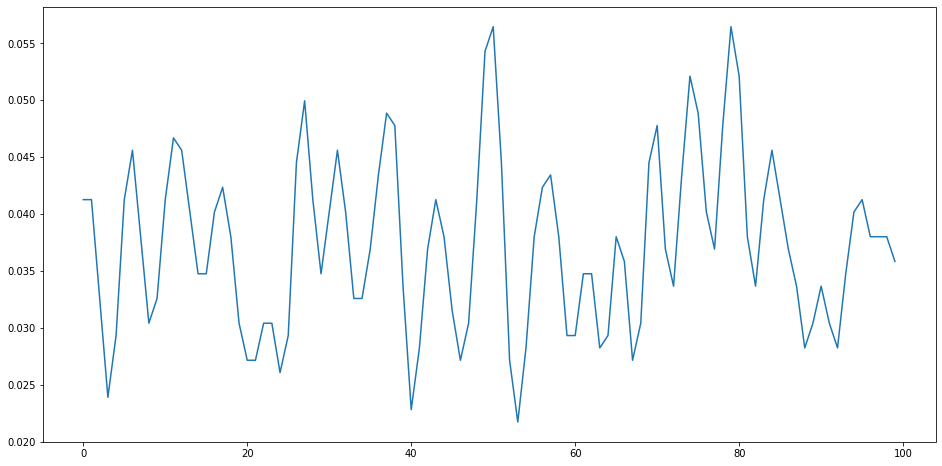

In [0]:
plt.figure(figsize=(16,8))
plt.plot(xtrain[0,:100])
plt.show()

In [0]:
xtrain.shape

(1677, 61440)

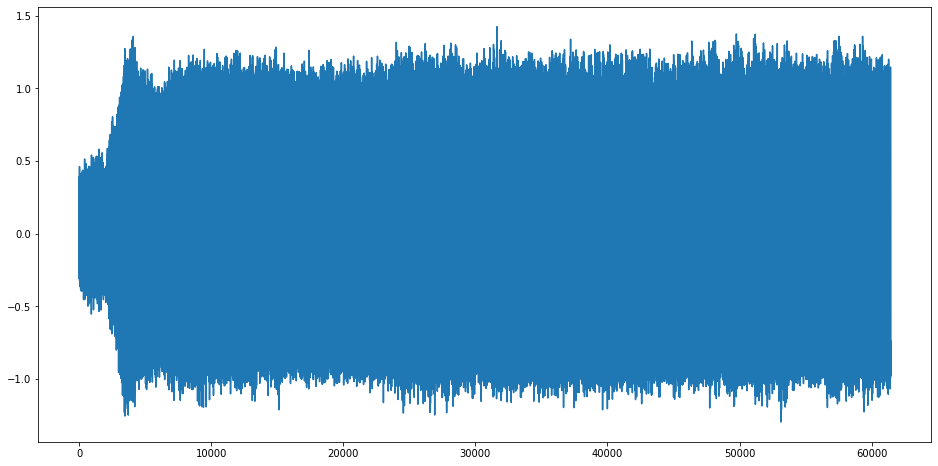

In [0]:
plt.figure(figsize=(16,8))
plt.plot(xtrain[1,:])
plt.show()

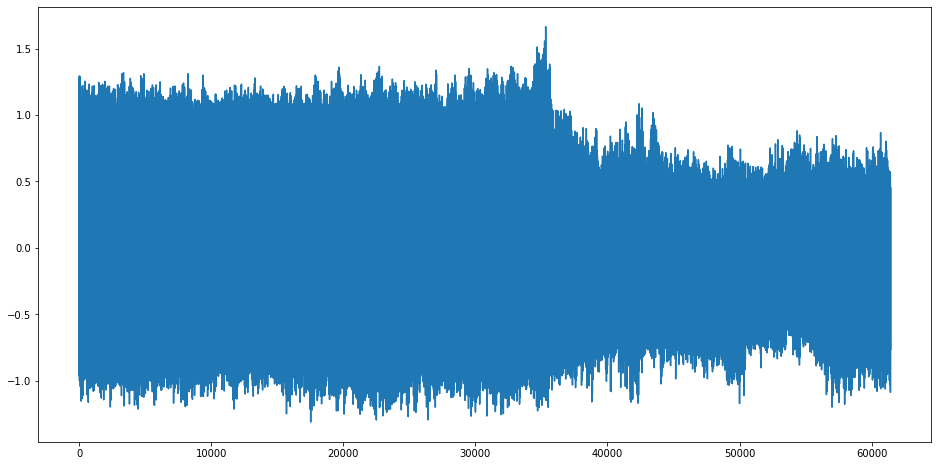

In [0]:
plt.figure(figsize=(16,8))
plt.plot(xtrain[10,:])
plt.show()

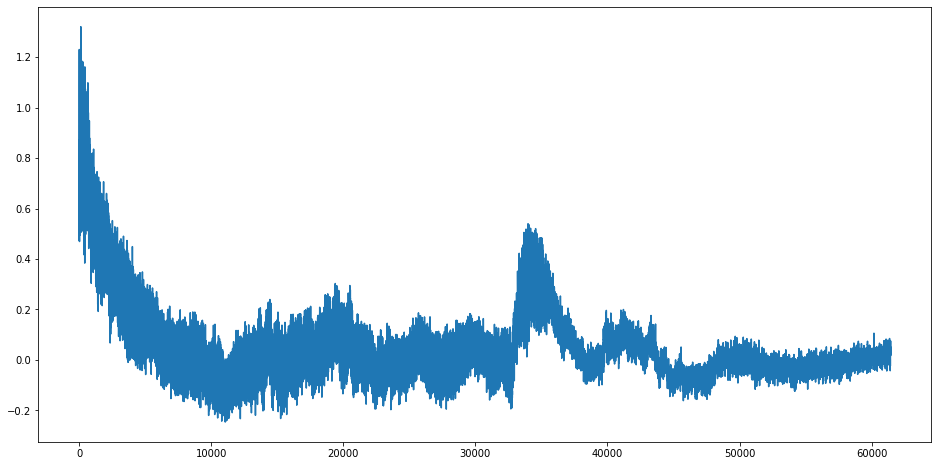

In [0]:
plt.figure(figsize=(16,8))
plt.plot(xtest[0,:])
plt.show()

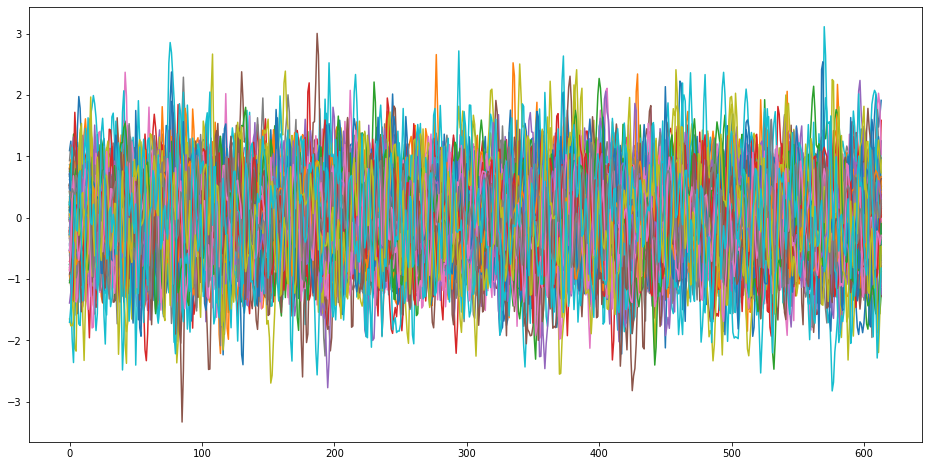

In [0]:
# Plot first 614 time points for first 100 observations
plt.figure(figsize=(16,8))
for i in range(100):
    plt.plot(range(614),xtrain[i,:614])
plt.show()

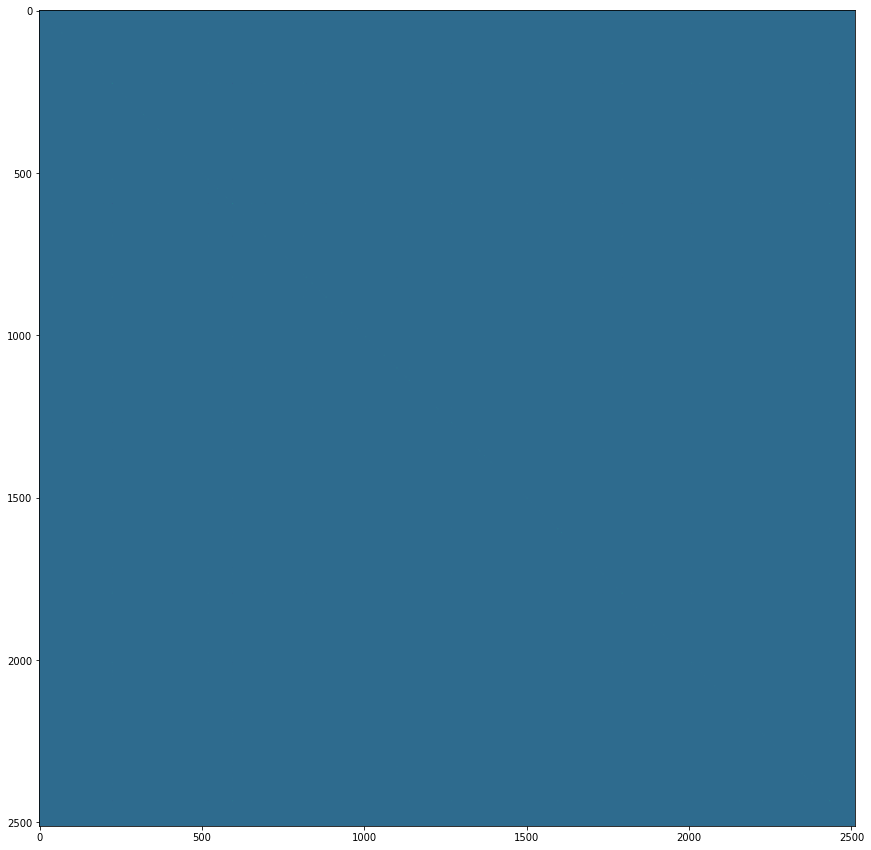

In [0]:
plt.figure(figsize=(15,15))
plt.imshow(X_train_cov)
plt.show()

# 3. Data preparation

## 3.7. xtrain without outliers

In [0]:
model_lof = LocalOutlierFactor(n_neighbors = 5, contamination = 'auto', novelty = False)
model_lof.fit(xtrain_feat)

LocalOutlierFactor(algorithm='auto', contamination='auto', leaf_size=30,
                   metric='minkowski', metric_params=None, n_jobs=None,
                   n_neighbors=10, novelty=False, p=2)

In [0]:
score_xtrain = -model_lof.negative_outlier_factor_ #.offset_ #.n_neighbors_
print(score_xtrain[:100])

[1.14894321 1.02740091 0.95265254 0.99584608 1.02553654 1.00833414
 1.08174896 1.00921812 1.12189957 0.99682778 1.11559796 0.99274604
 0.98394961 1.03594676 1.02715653 1.06643608 1.08723099 1.13852435
 0.9716844  1.02598204 1.04251157 1.01686322 1.12558343 1.04836736
 0.9849263  0.98964733 1.10477029 1.03059606 0.99587098 0.9870947
 1.01132112 1.05965479 1.08149106 1.03165506 1.11229675 1.03548021
 1.00130585 1.0406944  1.12530844 1.05094057 0.99535247 1.08260903
 1.17046229 1.06670353 1.00557188 1.06189469 1.00424268 1.01569926
 0.98416549 0.98592586 0.97097423 0.97289    1.00780648 1.01162495
 1.05393439 1.10908421 1.02383705 0.99370355 0.98512934 1.1087755
 1.01403267 1.01725706 1.01513419 0.99557804 1.01034418 1.02059903
 1.65806807 1.01362609 1.01836324 1.07515542 1.01098154 1.02987014
 0.96175308 1.07324275 0.99024914 1.01394612 1.17143067 1.06564869
 0.98541609 1.02832027 1.47703858 1.03446802 1.03423264 0.94365537
 1.03191113 1.00597102 1.01675998 0.99280772 0.98272529 0.959432

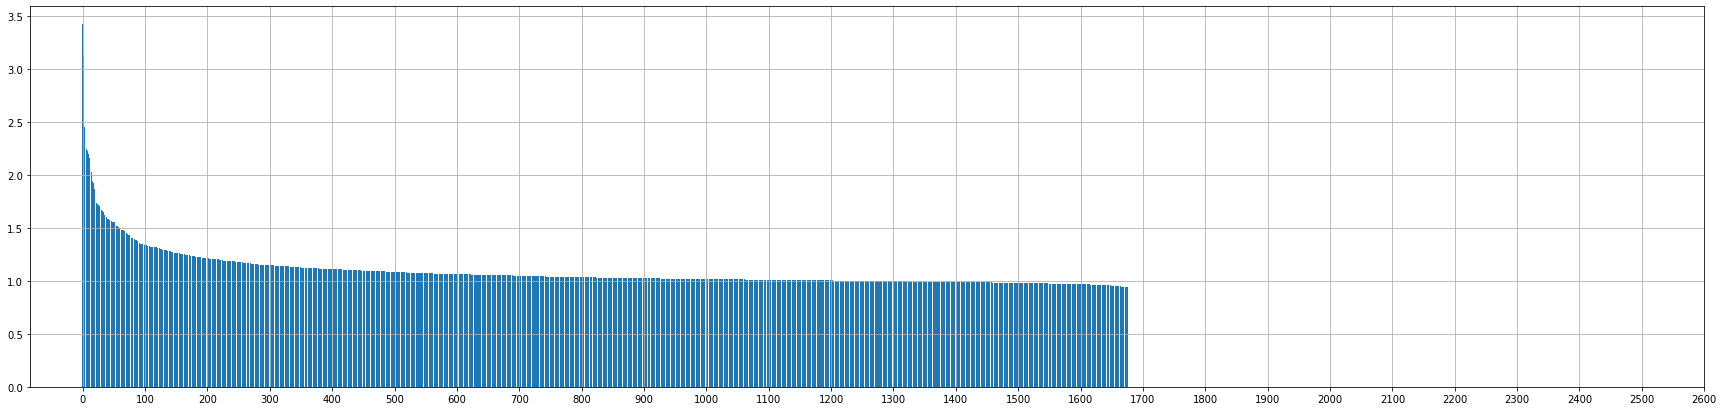

In [0]:
df_res2 = pd.DataFrame()
# minus signs are for sorting
df_res2["index"] = np.argsort(-score_xtrain)
df_res2["score"] = -np.sort(-score_xtrain)

plt.figure(figsize=(30,7))
plt.bar(range(df_res2.shape[0]), df_res2["score"])
plt.xticks(range(0,2700,100))
plt.grid()
plt.show()

In [0]:
list_indexes = df_res2[df_res2["index"] < 1677-1000]["index"].to_list()
len(list_indexes)

677

In [0]:
xtrain_without_outliers = np.take(xtrain, list_indexes, axis=0)
xtrain_without_outliers.shape

(677, 61440)

## 3.6. Slice time-series

In [0]:
xtrain.shape

(1677, 61440)

In [0]:
xtrain_sliced = np.concatenate((xtrain[:,:20480], xtrain[:,20480:20480*2], xtrain[:,20480*2:])) # 20480 = 61440/3
xtrain_sliced.shape   

(5031, 20480)

In [0]:
xtest_sliced = np.concatenate((xtest[:,:20480], xtest[:,20480:20480*2], xtest[:,20480*2:])) # 20480 = 61440/3
xtest_sliced.shape   

(7533, 20480)

In [0]:
# De-slice the score
sscore_sliced.shape

(7533,)

In [0]:
sscore = np.sum((sscore_sliced[:2511], sscore_sliced[2511:2511*2], sscore_sliced[2511*2:]), axis=0)  # 2511 = 7533/3
sscore.shape

(2511,)

## 3.5. T-SNE

In [0]:
import numpy as np
from sklearn.manifold import TSNE
X = np.array([[0, 0, 0], [0, 1, 1], [1, 0, 1], [1, 1, 1]])
X_embedded = TSNE(n_components=2).fit_transform(X)
print(X_embedded.shape)
X_embedded

(4, 2)


array([[325.9958  , 167.40208 ],
       [239.85898 , -57.06934 ],
       [101.5217  , 253.5319  ],
       [ 15.384936,  29.06047 ]], dtype=float32)

In [0]:
from sklearn.manifold import TSNE

X = np.array(xtest[:10])
X_embedded = TSNE(n_components=3).fit_transform(X)

print(X_embedded.shape)
X_embedded

(10, 3)


array([[ 523.1196  , -335.93964 ,  681.7289  ],
       [-467.30783 ,  373.5291  , -704.3747  ],
       [ -25.28888 , -585.36536 , -275.49524 ],
       [ 107.70808 ,  217.80943 ,  456.87152 ],
       [ 322.33328 ,  -32.659546,   10.477836],
       [ 499.60815 ,  614.5643  ,  227.87518 ],
       [   9.386404,  257.61688 , -249.78996 ],
       [-220.23637 ,   93.115074,  167.00981 ],
       [  14.750067, -235.07214 ,  -42.52049 ],
       [-601.86224 , -125.64766 , -164.93385 ]], dtype=float32)

In [0]:
X_embedded[:10]

array([[140.58572   ,  85.57845   ],
       [116.9906    ,  11.001481  ],
       [151.17596   , 133.2467    ],
       [205.22319   ,  42.67698   ],
       [192.66014   ,  93.97734   ],
       [ 96.16906   ,  56.894436  ],
       [154.51257   ,  45.175808  ],
       [ 97.62766   , 109.61025   ],
       [221.56595   , 103.87182   ],
       [171.66507   ,  -0.66423154]], dtype=float32)

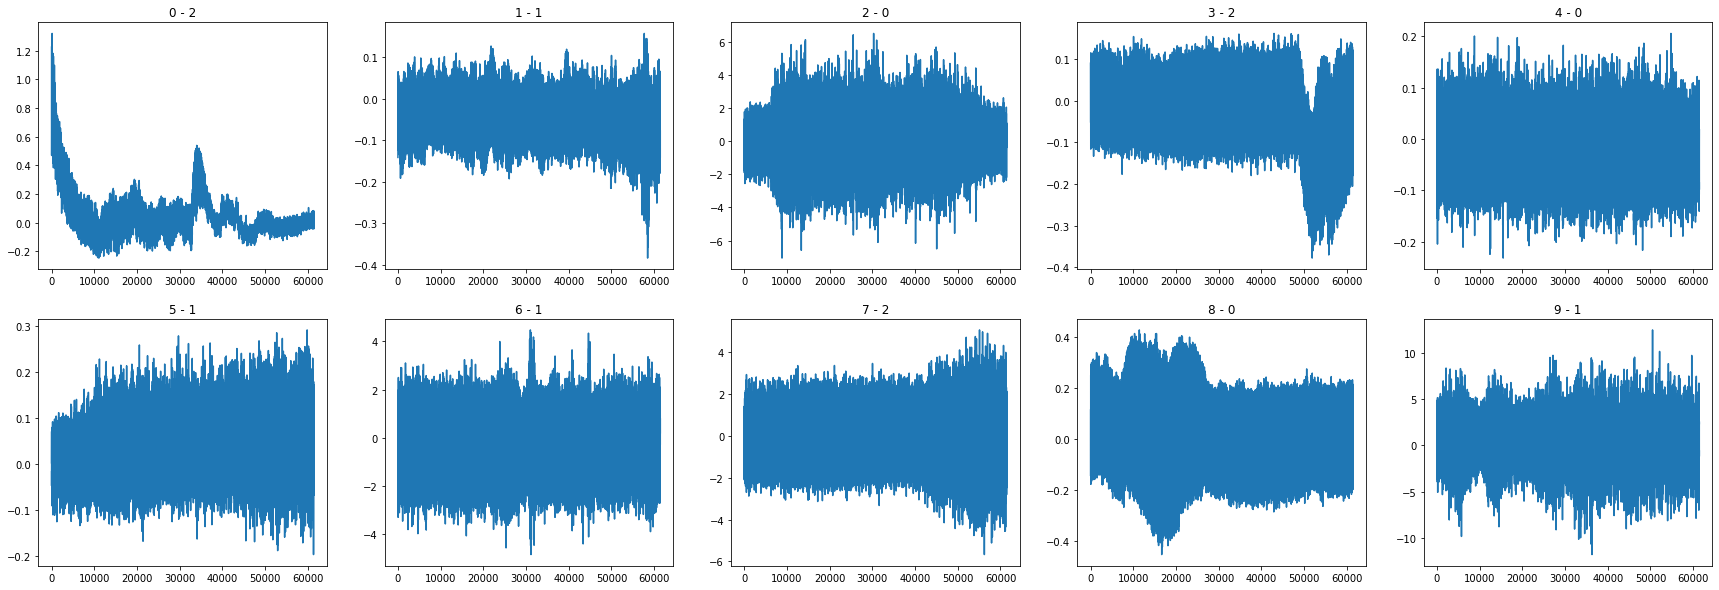

In [0]:
plt.figure(figsize=(30,10)) # x, y
for i in range(10):
  index = df_res["index"].iloc[i]
  plt.subplot(2,5,i+1)
  ax = plt.plot(xtest[i])
  plt.title(str(i) + " - " + str(X_embedded2[i]))
plt.show()

## 3.0. Moyenne mobile

In [0]:
from scipy.signal import lfilter

n = 1000  # the larger n is, the smoother curve will be
b = [1.0 / n] * n
a = 1
mm = lfilter(b, a, xtrain[0,:])

In [0]:
xtrain_rolling = xtrain.copy()
for i in range(xtrain.shape[0]):
  xtrain_rolling[i] =  lfilter(b, a, xtrain[i,:])

In [0]:
xtest_rolling = xtest.copy()
for i in range(xtest.shape[0]):
  xtest_rolling[i] =  lfilter(b, a, xtest[i,:])

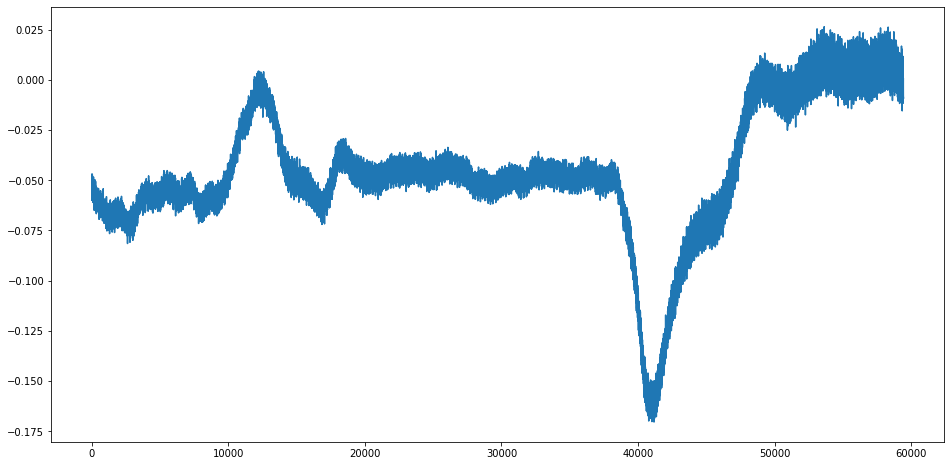

In [0]:
plt.figure(figsize=(16,8))
plt.plot(xtest_rolling[7,1000:-1000]) #7
plt.show()

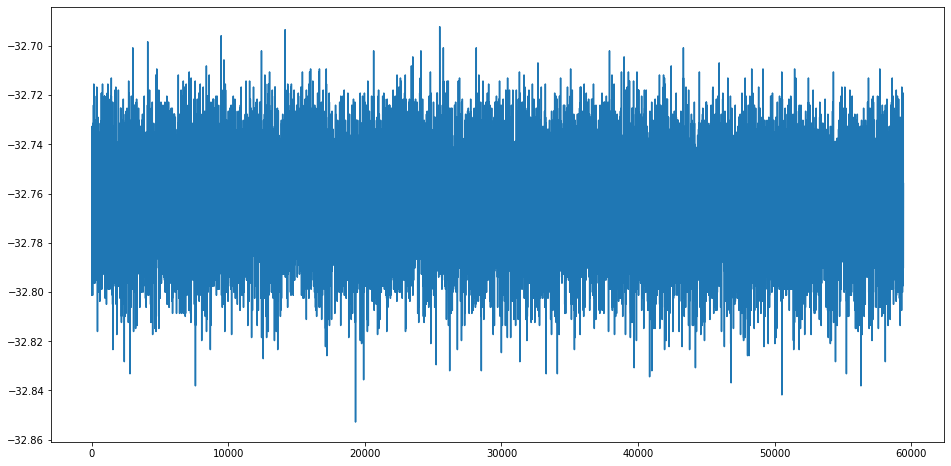

In [0]:
plt.figure(figsize=(16,8))
plt.plot(xtest[2125,1000:-1000])
plt.show()

## 3.1. Concatenate train and test

In [0]:
print(xtrain.shape)
print(xtest.shape)
xconcat = np.concatenate((xtrain, xtest), axis = 0)
xconcat.shape

(1677, 61440)
(2511, 61440)


(4188, 61440)

## 3.2. Scaler

In [0]:
xtrain_scaled[0].shape

(61440,)

In [0]:
from sklearn.preprocessing import Normalizer, StandardScaler, RobustScaler, MaxAbsScaler, MinMaxScaler

transformer = StandardScaler()  # fit does nothing.
#xtrain_scaled = transformer.fit_transform(xtrain)
#xtest_scaled = transformer.fit_transform(xtest)

for i in range(xtrain.shape[0]):
  xtrain_scaled[i] = transformer.fit_transform(xtrain[i].reshape(1, -1))
  
for i in range(xtest.shape[0]):
  xtest_scaled[i] = transformer.fit_transform(xtest[i].reshape(1, -1))
 

In [0]:
xtrain_scaled = np.empty([xtrain.shape[0], xtrain.shape[1]])
for i in range(xtrain.shape[0]):
  if (np.max(xtrain[i]) - np.mean(xtrain[i])) == 0:
    xtrain_scaled[i] = 0
  else:
    xtrain_scaled[i] = (xtrain[i] - np.mean(xtrain[i])) / (np.max(xtrain[i]) - np.mean(xtrain[i]))

xtest_scaled = np.empty([xtest.shape[0], xtest.shape[1]])
for i in range(xtest.shape[0]):
  if (np.max(xtest[i]) - np.mean(xtest[i])) == 0:
    xtest_scaled[i] = 0
  else:
    xtest_scaled[i] = (xtest[i] - np.mean(xtest[i])) / (np.max(xtest[i]) - np.mean(xtest[i]))

In [0]:
np.isnan(xtest_scaled).sum()

0

In [0]:
print(np.min(xtest[2040,:]))
print(np.max(xtest[2040,:]))
print(np.mean(xtest[2040,:]))

-22.16132
-22.16132
-22.161319999999993


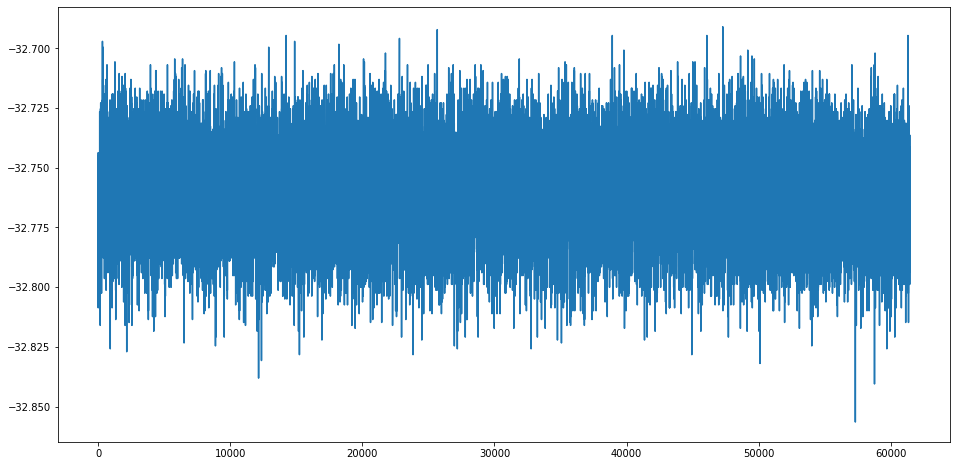

In [0]:
plt.figure(figsize=(16,8))
plt.plot(xtest[2272,:]) #2272
plt.show()

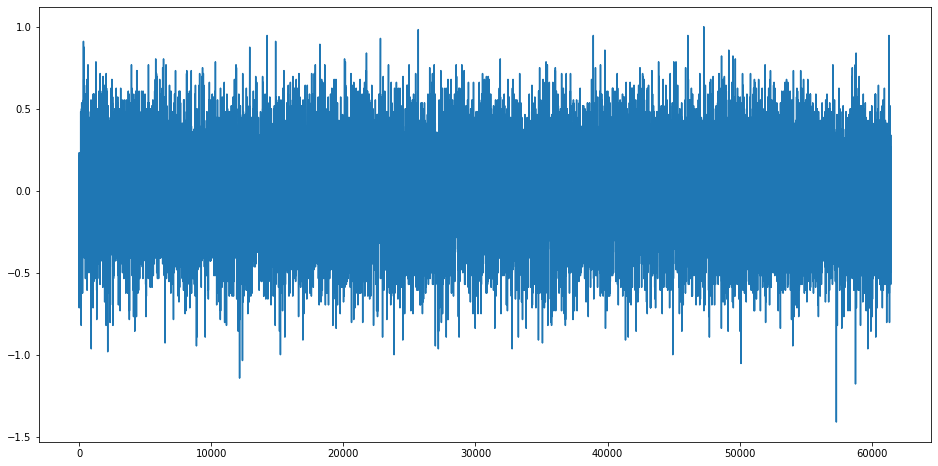

In [0]:
plt.figure(figsize=(16,8))
plt.plot(xtest_scaled[2272,:])
plt.show()

## 3.3. PCA

First option: Using the projection on a low-dimensional space

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

### Finding the optimal number of eigenvalues

In [0]:
%%time
cov_matrix = np.cov(xtrain_scaled) #_rolling[:,1000:-1000]
print("Shape of covariance matrix:", cov_matrix.shape)

Shape of covariance matrix: (1677, 1677)
CPU times: user 11.2 s, sys: 1.82 s, total: 13 s
Wall time: 3.77 s


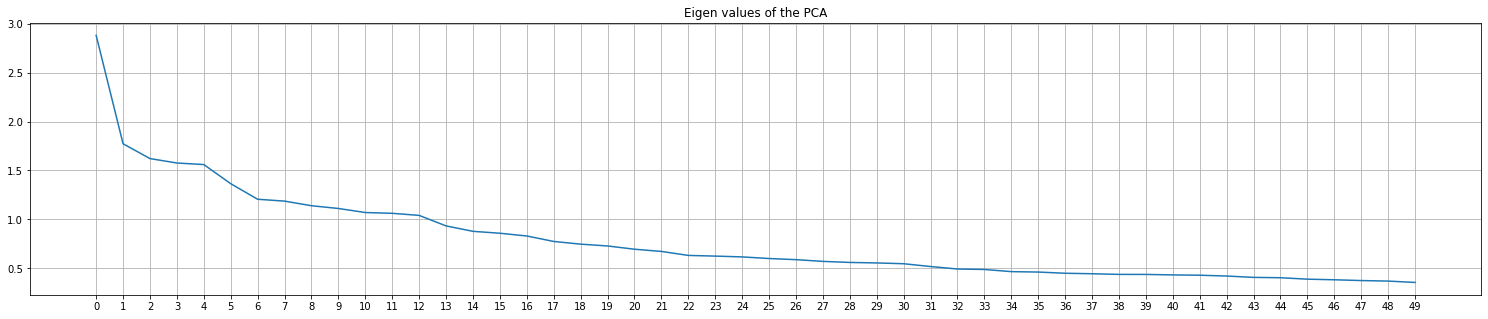

In [0]:
v, d, vt = np.linalg.svd(cov_matrix)
plt.figure(figsize=(26,5))
plt.plot(d[:50])
plt.title("Eigen values of the PCA")
plt.xticks(range(50))
plt.grid()
plt.show()

### PCA transformation

In [0]:
%%time
# PCA model
pca1 = PCA(n_components = 6, whiten = True, random_state=RANDOM_STATE)
pca1.fit(xtrain_scaled) #[:100,:]) #_rolling[:,1000:-1000]

# PCA fit_transform
xtrain_pca = pca1.transform(xtrain_scaled) #[:100,:]) #_rolling[:,1000:-1000]
xtest_pca = pca1.transform(xtest_scaled) #_rolling[:,1000:-1000]
print(xtrain_pca.shape)

(1677, 6)
CPU times: user 12.9 s, sys: 1.15 s, total: 14.1 s
Wall time: 4.57 s


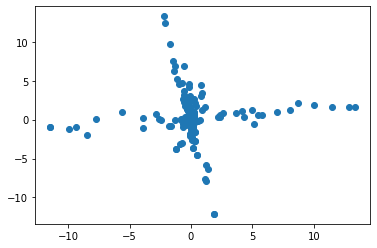

In [0]:
plt.scatter(xtrain_pca[:,0], xtrain_pca[:,1])
plt.show()

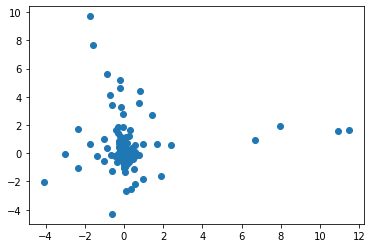

In [0]:
plt.scatter(xtest_pca[:,0], xtest_pca[:,1])
plt.show()

In [0]:
pca1_save = pca1
pca1_save.get_params()

{'copy': True,
 'iterated_power': 'auto',
 'n_components': 10,
 'random_state': 261,
 'svd_solver': 'auto',
 'tol': 0.0,
 'whiten': True}

## 3.4. Create feature set

- Calculer nombre d'extremas, la plus grosse variation locale (sur une courte zone), et essayer avec des pourcentages plutôt que des valeurs "arbitraires"

In [0]:
def compute_features(xset):
  xset_feat = pd.DataFrame(columns=["min", "max", "mean"]) #, "diff", "median", "std", "var", "progression", "p1", "p2", "p3", "p4", "p5", "p6", "p7", "p8", "p9"])
  xset_feat["min"] = np.min(xset, axis=1)
  xset_feat["max"] = np.max(xset, axis=1)
  xset_feat["mean"] = np.mean(xset, axis=1)
  #xset_feat["diff"] = xset_feat["max"] - xset_feat["min"]
  #xset_feat["std"] = np.std(xset, axis=1)
  #xset_feat["start"] = np.mean(xset[:,:100],axis=1)
  #xset_feat["end"] = np.mean(xset[:,-100:],axis=1)
  #start = np.mean(xset[:,:100],axis=1)
  #end = np.mean(xset[:,-100:],axis=1)
  #xset_feat["progression"] = end - start
  #xset_feat["var"] = np.var(xset, axis=1)
  #xset_feat["median"] = np.median(xset, axis=1)

  """percentiles = np.percentile(xset, range(10,100,10), axis=1)
  xset_feat["p1"] = percentiles[0]
  xset_feat["p2"] = percentiles[1]
  xset_feat["p3"] = percentiles[2]
  xset_feat["p4"] = percentiles[3]
  xset_feat["p5"] = percentiles[4]
  xset_feat["p6"] = percentiles[5]
  xset_feat["p7"] = percentiles[6]
  xset_feat["p8"] = percentiles[7]
  xset_feat["p9"] = percentiles[8]"""
  return xset_feat

In [0]:
xtrain_feat = compute_features(xtrain) #_rolling[:,300:-300])
xtrain_feat.head()

,min,max,mean
0,-1.102304,1.0,-1.633531e-17
1,-0.915004,1.0,-7.806256e-18
2,-1.012862,1.0,-5.948656e-18
3,-1.056322,1.0,-1.084202e-19
4,-0.909228,1.0,7.285839e-18


In [0]:
xtest_feat = compute_features(xtest) #_rolling[:,300:-300])
xtest_feat.head()

,min,max,mean
0,-0.235475,1.0,9.251859e-19
1,-1.679146,1.0,-7.401487e-18
2,-1.074380,1.0,-3.411623e-18
3,-1.983894,1.0,3.145632e-17
4,-0.985455,1.0,0.000000e+00


In [0]:
print(np.percentile(df_res["score"], range(10,100,10)))

[0.962667 0.984259 1.009044 1.036219 1.102648 1.271626 1.642558 2.206495
 4.456302]


In [0]:
print(describe(result))
print("Percentiles:")
print(np.percentile(result, range(5,100,5)))

DescribeResult(nobs=2511, minmax=(0.905055, 192.594448), mean=6.249670625647152, variance=465.6409270975452, skewness=5.561908478211947, kurtosis=32.78467081121296)
Percentiles:
[ 0.948993   0.962667   0.972952   0.984259   0.995865   1.009044
  1.019247   1.036219   1.053577   1.102648   1.179808   1.271626
  1.4113555  1.642558   1.898987   2.206495   2.783985   4.456302
 32.158002 ]


## 3.5. Concatenate PCA and feature columns

In [0]:
xtrain_pca.shape

(99, 32)

In [0]:
xtrain_feat.shape

(1677, 3)

In [0]:
xtrain_pca_feat = np.concatenate((xtrain_pca, xtrain_feat), axis=1)
print(xtrain_pca_feat.shape)

(1677, 13)


In [0]:
xtest_pca_feat = np.concatenate((xtest_pca, xtest_feat), axis=1)
print(xtest_pca_feat.shape)

(2511, 13)


# 4. Models

## 4.1. Local Outlier Factor

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html

In [0]:
# Fit the low-dimensional method
model_lof = LocalOutlierFactor(n_neighbors = 5, contamination = 'auto', novelty = True)
model_lof.fit(xtrain_pca[1:131]) #[1:131])

# Calculate anomaly score on the (PCA-transformed) test data
sscore = -model_lof.score_samples(xtest_pca)
print(sscore[:100])

[1.06753845 1.26952861 2.14493129 1.65689039 1.26352809 0.95579791
 1.70164389 0.96409598 1.02834734 1.71809528 1.48132248 1.00697788
 0.90986505 1.30190398 5.09824368 0.94732624 0.98881848 0.95963015
 1.45261568 1.88271535 2.22126092 2.55739754 1.2817319  3.07578967
 2.24501925 0.94732624 1.07281122 2.90280191 1.48123332 1.34939996
 1.54827289 1.59418639 1.11161911 1.09884409 0.99983747 2.14479181
 1.97896409 1.64454694 1.3942011  1.78453759 1.65684699 2.18279763
 2.85021724 0.98699877 4.16753187 1.26238545 2.11344076 1.44844533
 2.38056055 1.04855684 1.16142862 1.03356528 1.7969466  1.53693255
 1.68854234 1.12415786 1.23639347 1.72416836 2.60760004 3.02009897
 2.58380957 3.19457368 2.70798819 1.48346908 1.2277368  1.19719681
 1.71803989 2.07000325 1.69900922 2.30721924 1.08508371 1.21082692
 2.1042722  1.24336339 1.1188868  2.077134   1.33361884 1.08219428
 2.2415734  1.45786002 2.16667332 3.03095183 1.90461402 0.97345791
 2.35634697 1.69652835 0.99381902 1.37446987 2.82980403 2.1066

In [0]:
# Reseparate test if we did xconcat
#sscore = sscore[xtrain.shape[0]:]

In [0]:
#sscore = -model_lof.negative_outlier_factor_ #.offset_ #.n_neighbors_
#print(sscore[:100])

## 4.2. OneClassSVM

https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html

In [0]:
%%time

# Fit the low-dimensional method
clf = OneClassSVM().fit(xtrain_feat)

# Calculate anomaly score on the (PCA-transformed) test data
sscore_oneclass = -clf.score_samples(xtest_feat)
print(sscore_oneclass[:100])

[-5.09596299e+02 -4.86109772e+02 -2.53678214e+02 -4.86144952e+02
 -4.82926099e+02 -4.85165204e+02 -4.29064353e+02 -3.70418078e+02
 -4.99701257e+02 -2.95323704e+01 -3.70940210e+02 -4.80813255e+02
 -4.77128347e+02 -4.74298199e+02 -4.77809481e+02 -4.87359245e+02
 -4.76552495e+02 -4.99631408e+02 -4.91915457e+02 -4.84989544e+02
 -4.98400132e+02 -4.85228673e+02 -4.83493186e+02 -4.79917294e+02
 -1.41365273e-03 -4.81553160e+02 -4.72226297e+02 -4.76651465e+02
 -5.04091758e+02 -4.72204145e+02 -4.96316084e+02 -4.83045209e+02
 -5.25494171e+02 -4.82060444e+02 -5.37424689e+02 -4.56020535e+02
 -4.77740385e+02 -1.23683959e-02 -4.64959306e+02 -9.55088937e+01
 -4.73201459e+02 -5.00519139e+02 -5.19423342e+02 -4.65442110e+02
 -4.74081985e+02 -4.76194452e+02 -1.18203377e+02 -4.74242961e+02
 -2.31128440e+02 -1.28600724e+02 -4.96530161e+02 -5.12283924e+02
 -4.70979148e+02 -5.22231534e+02 -8.88874089e+01 -4.85924381e+02
 -4.82684273e+02 -5.15155245e+02 -5.03847731e+02 -4.84681447e+02
 -5.02010969e+02 -4.19064

## 4.3. Stacking

In [0]:
sscore_pca_rank = rankdata(sscore_pca)
sscore_feat_rank = rankdata(sscore_feat)

In [0]:
sscore_oneclass_rank = rankdata(sscore_oneclass) 

In [0]:
sscore = np.max((sscore_pca_rank, sscore_feat_rank), axis=0)
sscore.shape

(2511,)

In [0]:
print(sscore[:25])

[3429.  2795.  3942.  2176.  3130.  2642.  3588.  3639.  3100.  6671.
 3678.  4672.  5301.  4462.  4982.  3476.  3820.  1620.  2348.  4199.
  796.5 4147.  2999.  2297.  7119. ]


# 5. Result analysis

## 5.1. Evaluate past submission

DescribeResult(nobs=2511, minmax=(0.905055, 192.594448), mean=6.249670625647152, variance=465.6409270975452, skewness=5.561908478211947, kurtosis=32.78467081121296)
Percentiles:
[ 0.948993   0.962667   0.972952   0.984259   0.995865   1.009044
  1.019247   1.036219   1.053577   1.102648   1.179808   1.271626
  1.4113555  1.642558   1.898987   2.206495   2.783985   4.456302
 32.158002 ]


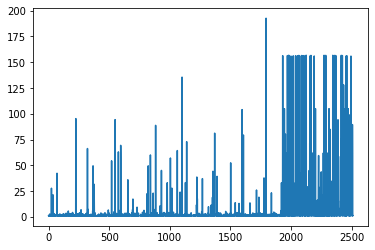

In [0]:
result = np.loadtxt(ROOT + 'submissions/submission_19.csv', delimiter= ' ')
df_res = pd.DataFrame()
df_res["index"] = np.argsort(-result)
df_res["score"] = -np.sort(-result)

print(describe(result))
print("Percentiles:")
print(np.percentile(result, range(5,100,5)))
plt.plot(result)
plt.show()

In [0]:
for i in range(len(result)):
  if (result[i] > 103) & (result[i] < 105):
    print(i)
    result[i] = 0.9915
  
  if (result[i] > 61.7) & (result[i] < 62):
    print(i)
    result[i] = 0.9915

1596
1938
1945
1960
1971
1996
1998
2002
2040
2107
2109
2124
2156
2160
2175
2196
2201
2266
2292
2297
2313
2320
2368
2372
2379
2444
2464
2470
2507


In [0]:
df_res.head()

,index,score
0,1607,33.826258
1,596,16.753268
2,1005,16.154798
3,549,14.581993
4,520,13.504306


In [0]:
result[2378]

2.839574

In [0]:
df_res.head(10)

In [0]:
df_res.tail(10)

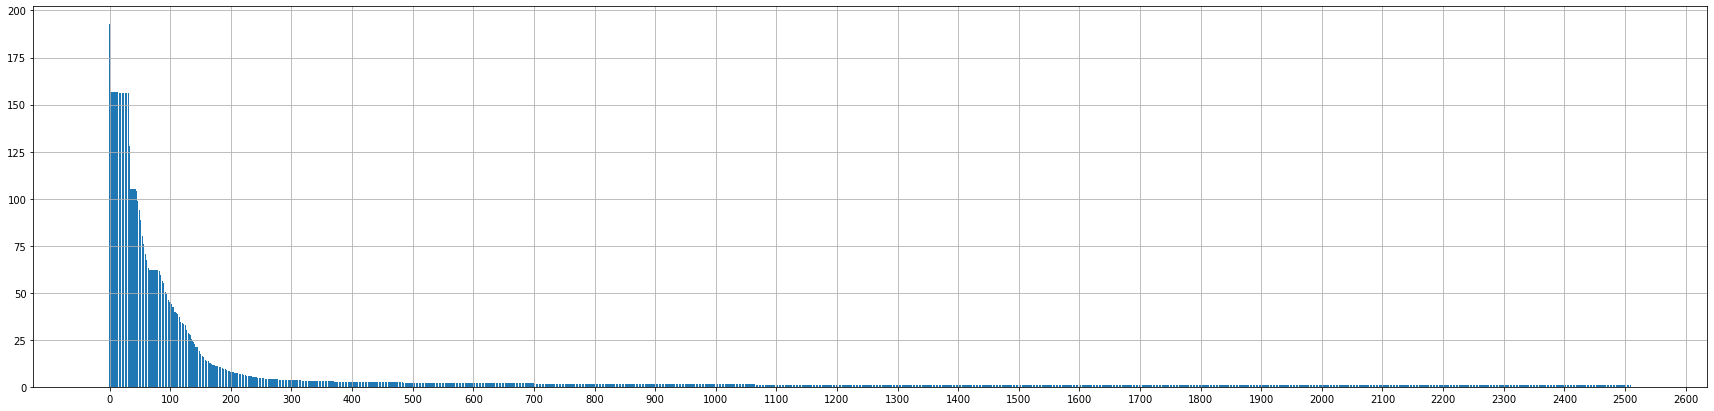

In [0]:
plt.figure(figsize=(30,7))
plt.bar(range(df_res.shape[0]), df_res["score"])
plt.xticks(range(0,2700,100))
plt.grid()
plt.show()

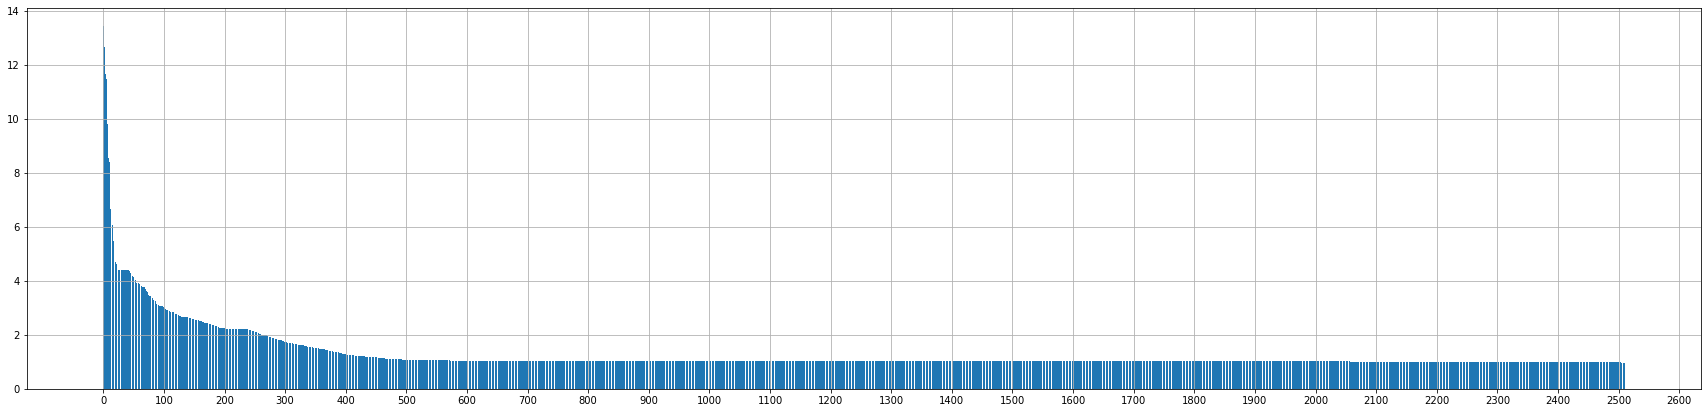

In [0]:
# Submission 5
plt.figure(figsize=(30,7))
plt.bar(range(df_res.shape[0]), df_res["score"])
plt.xticks(range(0,2700,100))
plt.grid()
plt.show()

## 5.2. Compare past submissions

In [0]:
nb_submissions = 46
df_submissions = pd.DataFrame()
for i in range(1, nb_submissions+1):
  df_submissions[str(i)] = np.loadtxt(ROOT + 'submissions/submission_' + str(i) + '.csv', delimiter= ' ')
df_submissions = df_submissions.rank(axis = 0, method='max', ascending=False)
#df_submissions["mean"] = np.mean(df_submissions, axis=1)
print(df_submissions.shape)
df_submissions.head()

(2511, 46)


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46
0,289.0,286.0,1935.0,223.0,314.0,225.0,318.0,354.0,419.0,378.0,354.0,330.0,381.0,128.0,381.0,405.0,84.0,125.0,2128.0,1223.0,2128.0,2128.0,2128.0,486.0,2128.0,1199.0,556.0,381.0,1608.0,455.0,640.0,1626.0,1600.0,1591.0,2041.0,975.0,2047.0,1610.0,1671.0,1671.0,1585.0,388.0,451.0,357.0,415.0,2101.0
1,2142.0,2087.0,565.0,1890.0,1811.0,2344.0,2154.0,2478.0,1388.0,1950.0,2478.0,2037.0,1238.0,982.0,1238.0,854.0,1195.0,1623.0,1541.0,1625.0,1510.0,1510.0,1512.0,289.0,1541.0,1210.0,643.0,331.0,1335.0,1347.0,1341.0,1353.0,1352.0,1327.0,911.0,1383.0,1530.0,1366.0,1055.0,1055.0,1334.0,1019.0,1608.0,1697.0,1820.0,1594.0
2,936.0,2321.0,1882.0,1019.0,747.0,590.0,994.0,1082.0,734.0,632.0,1082.0,590.0,1600.0,624.0,1600.0,1267.0,393.0,619.0,969.0,755.0,938.0,938.0,940.0,2018.0,969.0,526.0,1728.0,2325.0,685.0,632.0,658.0,569.0,630.0,995.0,462.0,487.0,428.0,479.0,514.0,514.0,861.0,1728.0,1804.0,2085.0,2161.0,438.0
3,663.0,658.0,51.0,544.0,751.0,867.0,727.0,1178.0,643.0,965.0,1178.0,844.0,1314.0,612.0,1314.0,1709.0,289.0,433.0,2026.0,2074.0,2026.0,2026.0,2026.0,524.0,2026.0,2509.0,434.0,387.0,1354.0,1375.0,1365.0,1374.0,1355.0,1329.0,931.0,1387.0,1528.0,1368.0,1180.0,1180.0,1337.0,727.0,2127.0,1056.0,2434.0,1597.0
4,1827.0,1713.0,239.0,1765.0,1577.0,2140.0,1740.0,1082.0,1827.0,1154.0,1082.0,1198.0,1444.0,1604.0,1444.0,1481.0,1356.0,1199.0,2343.0,2481.0,2343.0,2343.0,2343.0,1066.0,2343.0,2509.0,631.0,913.0,1147.0,1167.0,1155.0,1161.0,1158.0,1137.0,1145.0,1200.0,1329.0,1176.0,1249.0,1249.0,1139.0,2069.0,2294.0,1401.0,1849.0,1420.0


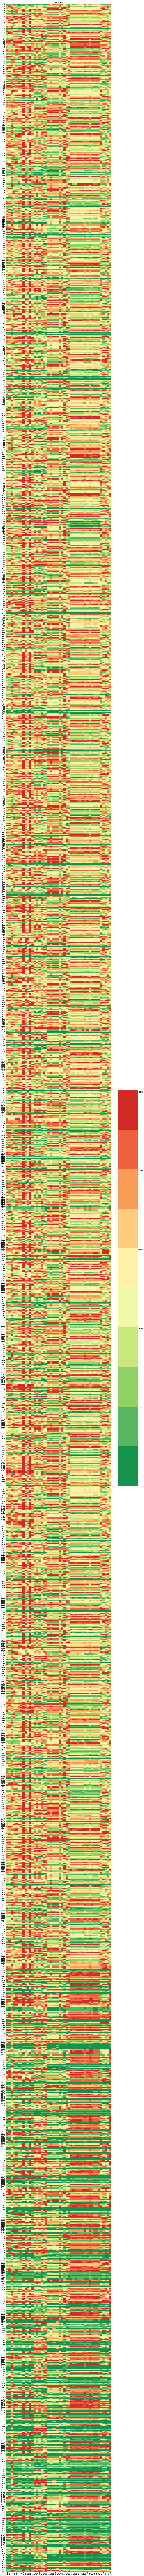

In [0]:
plt.figure(figsize=(15,300))
sns.heatmap(df_submissions, cmap=sns.color_palette("RdYlGn_r", 10))
plt.show()

In [0]:
# Same but horizontal display
nb_submissions = 46
df_submissions = pd.DataFrame()
for i in range(1, nb_submissions+1):
  df_submissions[str(i)] = np.loadtxt(ROOT + 'submissions/submission_' + str(i) + '.csv', delimiter= ' ')
df_submissions = df_submissions.T
df_submissions = df_submissions.rank(axis = 0, method='max', ascending=False)
print(df_submissions.shape)

plt.figure(figsize=(40,5))
sns.heatmap(df_submissions, cmap=sns.color_palette("RdYlGn_r", 10)) #, xticklabels=corr_train.columns, yticklabels=corr_train.columns)
#sns.heatmap(df_submissions.iloc[:,300:400], cmap=sns.color_palette("RdYlGn_r", 10)) #, xticklabels=corr_train.columns, yticklabels=corr_train.columns)
plt.show()

In [0]:
sscore_sliced[:2511] + sscore_sliced[2511:2511*2] + sscore_sliced[2511*2:]

(44, 2511)

In [0]:
df_submissions = pd.DataFrame()
df_submissions["1"] = sscore_sliced[:2511]
df_submissions["2"] = sscore_sliced[2511:2511*2]
df_submissions["3"] = sscore_sliced[2511*2:]
df_submissions = df_submissions.rank(axis = 0, method='max', ascending=False)
#df_submissions["mean"] = np.mean(df_submissions, axis=1)
print(df_submissions.shape)
df_submissions.head()

(2511, 3)


,1,2,3
0,584.0,1801.0,1286.0
1,1131.0,1179.0,1633.0
2,395.0,407.0,423.0
3,1218.0,1248.0,1634.0
4,1503.0,1378.0,1442.0


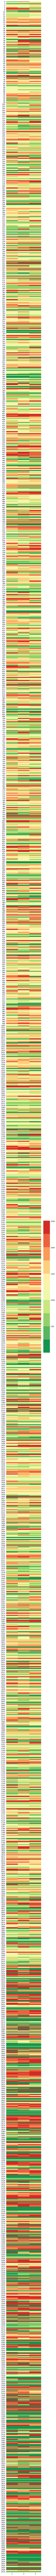

In [0]:
plt.figure(figsize=(5,300))
sns.heatmap(df_submissions, cmap=sns.color_palette("RdYlGn_r", 10))
plt.show()

## 5.3. Evaluate current score

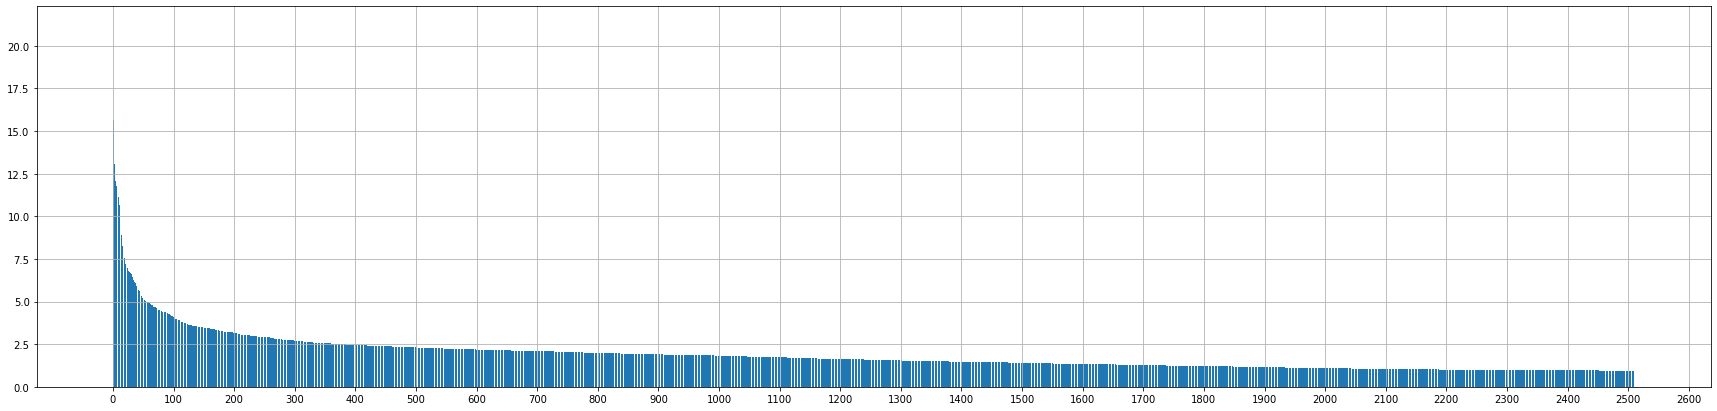

In [0]:
df_res = pd.DataFrame()
# minus signs are for sorting
df_res["index"] = np.argsort(-sscore)
df_res["score"] = -np.sort(-sscore)

plt.figure(figsize=(30,7))
#plt.bar(range(9, df_res.shape[0]), df_res["score"][9:])
plt.bar(range(df_res.shape[0]), df_res["score"])
plt.xticks(range(0,2700,100))
plt.grid()
plt.show()

In [0]:
sscore[225]

1.6670384661553652

In [0]:
df_res.head(10)

,index,score
0,2004,9.857172
1,2388,9.582680
2,2256,9.148852
3,2138,7.643464
4,2105,7.034056
5,1805,6.752022
6,2389,6.581182
7,2358,6.317093
8,2094,6.304079
9,1705,6.017770


In [0]:
df_res.tail(10)

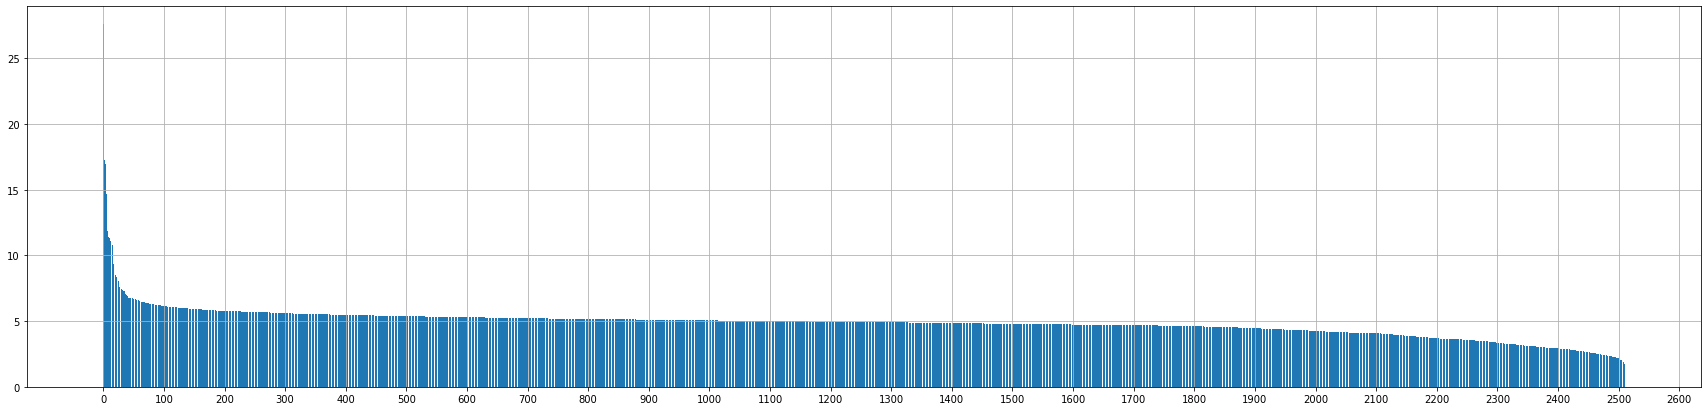

In [0]:
# soumission classique (PCA 10 components, xtrain en entier, LOF model)
"""plt.figure(figsize=(30,7))
plt.bar(range(df_res.shape[0]), df_res["score"])
plt.xticks(range(0,2700,100))
plt.grid()
plt.show()"""

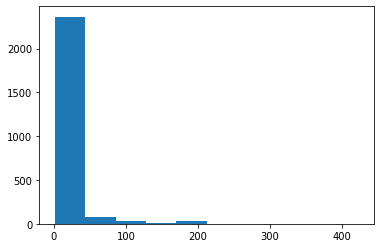

In [0]:
plt.hist(sscore)
plt.show()

In [0]:
df_res.head(10)

,index,score
0,2125,71.416124
1,2272,71.410526
2,2344,71.396582
3,2414,71.387868
4,1980,71.381028
5,2286,71.373536
6,2164,71.361933
7,2064,71.353416
8,2363,71.344966
9,1983,71.337282


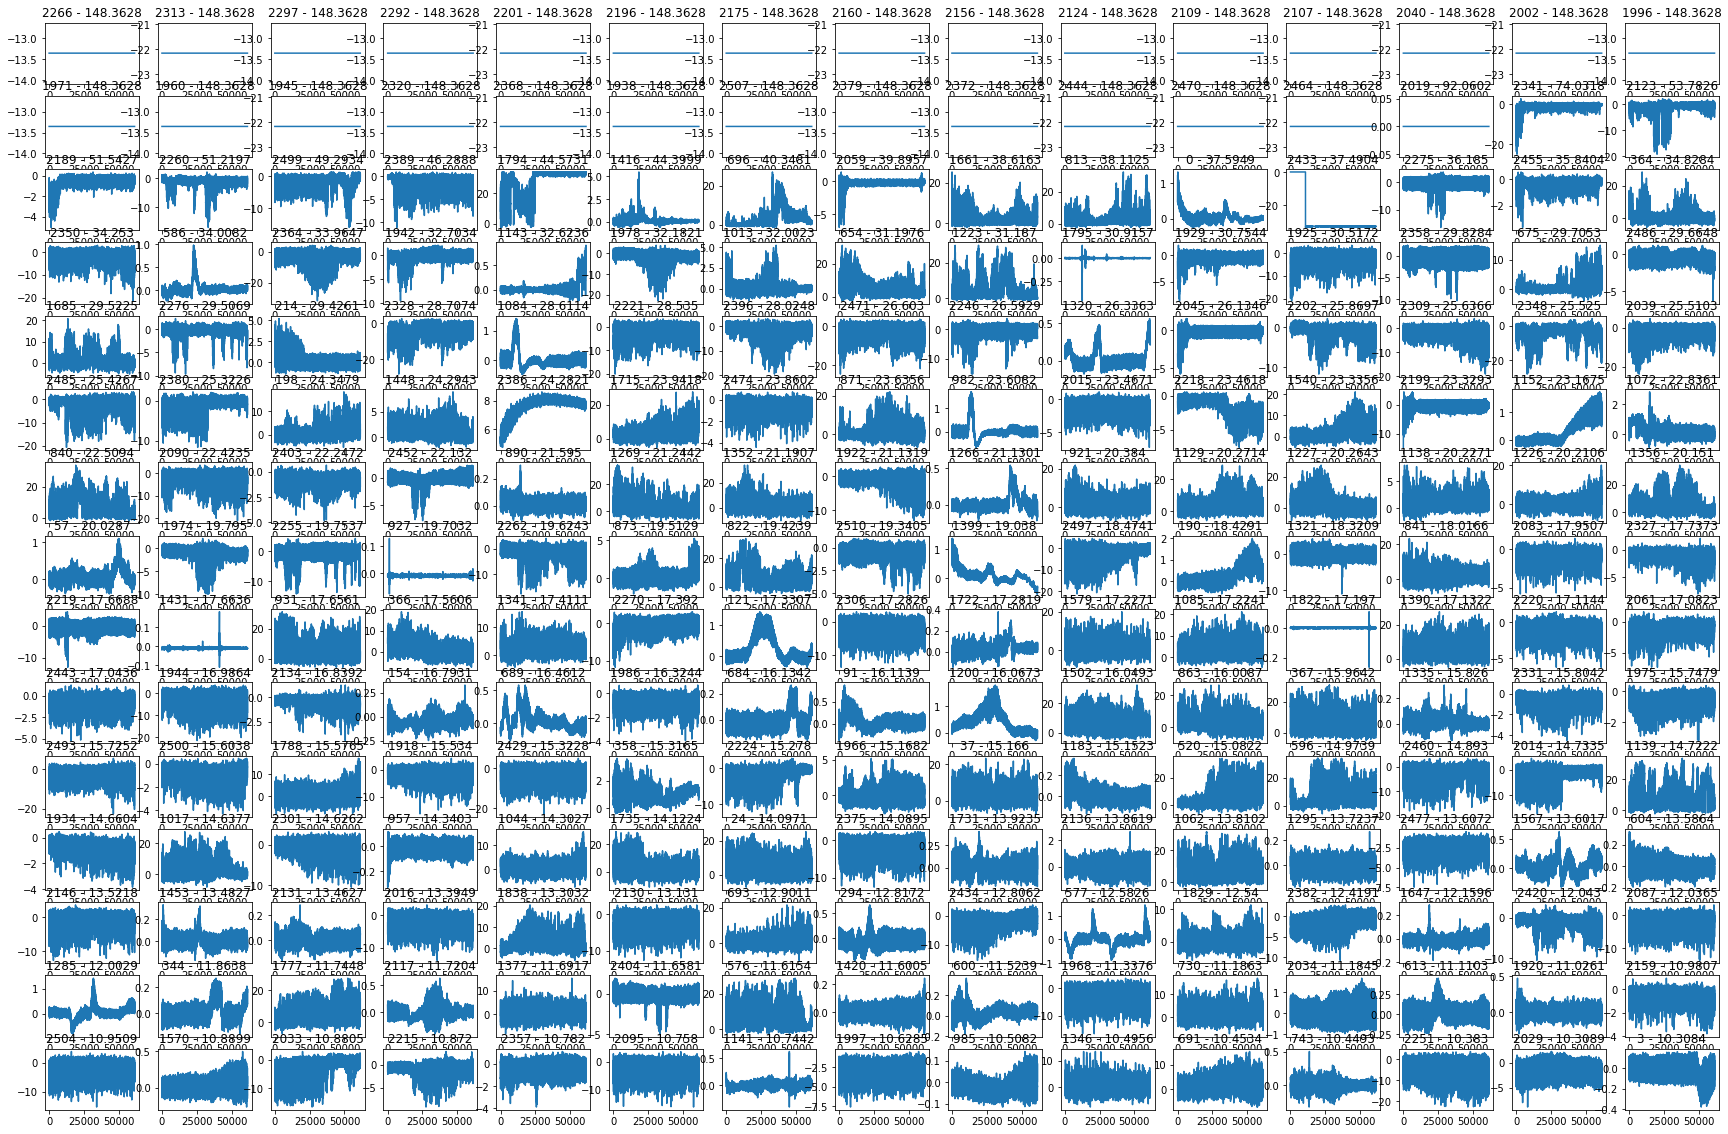

In [0]:
plt.figure(figsize=(30,20)) # x, y
for i in range(0,225):
  index = df_res["index"].iloc[i]
  plt.subplot(15,15,i+1)
  ax = plt.plot(xtest[index]) #xtest_rolling[index,1000:-1000])
  plt.title(str(index) + " - " + str(round(df_res["score"].iloc[i],4)))
plt.show()

# 6. Submission

In [0]:
# Save the anomaly scores to file
print(sscore.shape)
np.savetxt(ROOT + 'submissions/submission_59.csv', sscore, fmt = '%1.6f', delimiter=',')

(2511,)


* 1: fichier de base (score: 0.706630761244)
* 2: idem mais PCA sur tout le jeu de données (score: 0.714321690336)
* 3: idem mais PCA sur tout le jeu de données aussi pour calculer xtrain_fpca (score: 0.52)
* 4: retour v1 mais avec n_components = 8 pour la pca
* **5**: retour v1 mais avec n_components = 10 (je pensais avoir soumis pareil que le 2) (0.746458897252)
        -> Le seed influe beaucoup sur la PCA
* 6: idem, seed à 261 (0.70)
* 7: idem, seed à 8 (0.7072)
* 8: idem, seed remis à RANDOM_STATE (261) et n_neighbors = 20 pour LFO (0.721539854401)
* 9: xtest au lieu de xtrain, n_components = 5 et n_neighbors = 20 (0.710120879528)
* 10: idem mais n_components = 10 (0.710219758488)
* 11: xconcat (xtrain + xtest) pour le train, n_components = 10 et n_neighbors = 20 (0.721539854401). Même score avec xconcat que xtrain (normal car on prenait que les 100 premières rows pour fit le Lof)
* 12: OneClassSVM toute simple, gamma= auto (0.693180132745)
* 13: Lof trained with xtest and score obtained with *negative_outlier_factor_* (0.608454769056)
* 14: idem, but with PCA (5 components) trained on xtest (0.637194556713)
* 15: idem but PCA 10 components (0.608454769056)
* 16: idem but PCA 3 components (0.63060365605)
        -> 5 components is better than 10 and 3 on PCA
* 17: PCA with xconcat (n_components = 5), LFO with xtest (0.58350946148)
* 18: PCA with xconcat (n=5) and LFO on xconcat (extraction of the last scores, corresponding to xtest part) (0.593244404069)
* **19**: **soumission de base**: PCA (n=11) fittée sur tout xtrain, puis appliquée sur xtrain et xtest puis LFO (n=5) (0.592950857157)
* 20: idem sauf que LFO (n=10) (0.603503096147)
* 21: idem que 19, mais avec un score très bas mis pour les 30 premiers résultats (courbes homogènes mais valeurs vers -38) (0.561155091648)
* 22: erreur (même soumission que 21)
* 23: même principe que 21 mais en enlevant cette fois les courbes toutes plates, à 0 (0.552676220846)
* **24**: dataframe created from features (min, max, mean, etc.) (0.714724931094)
* 25: idem que 19
* 26: idem que 19 mais PCA et modèle fit sur xtrain[100:] (0.611723954664)
        -> Meilleur score obtenu, peut-être que s'entraîner sur qu'une partie des observations améliore le modèle
* **27**: comme la soumission de base (sauf PCA = 10), mais avec les colonnes ajoutées des features (donc 10+13 colonnes) (0.722596623284)
* **28**: idem que 24 mais sans les percentiles. D'ailleurs LFO n=5 (0.733363615015)
* **29**: idem que 28 mais LOF entraîné sur xtrain[1,131] (0.774044582051)
      -> Le dataframe des features donne des meilleurs résultats que le dataframe de base réduit avec une PCA
* 30: idem mais ajout de start (moyenne des 100 premières valeurs), end (moyenne des 100 dernières valeurs), progression (end - start) (0.771676121967)
* 31: idem mais sans start et end (0.771189452087)
* 32: idem but without progression, and var added (0.76720339402)
* 33: idem but keep var and remove std (0.767444411485)
* **34**: idem but keep only min, max, mean (0.775822858344)
* 35: idem, only max and mean (0.751178822599)
* 36: idem, only min, max, mean, xtrain[:100], to compare with sub 34 (0.76263024213)
* 37: idem, but xtrain[1:289] and LOF (n=100) (0.707186955393)
* 38: idem, but LOF (n=5) (0.761964354135)
      -> xtrain[1,131] (0.77) est mieux que xtrain[:100] (0.762) et xtrain[1:289] (0.761)
* 39: idem que 34, et concatenation avec une PCA (n =10) sur tout le jeu de données. Donc 13 colonnes au total (0.769823686455)
* 40: error
* 41: idem que 34, median added (0.77493912764)
* 42: moyenne mobile de 200, on retire les 300 premières valeurs à gauche et à droite puis on fait le set de features (min, max, mean) puis LFO (0.730012545268)
* 43: idem pour la moyenne mobile, mais on retire les 400 premières et dernières valeurs, puis on fait une PCA (n = 7) puis LFO (0.741069993944)
* 44: idem mais moyenne mobile sur 1000 (ça trace des courbes bien distinctes), on retire les 1000 premières et dernières puis PCA (n = 10) puis LFO (0.740401015981)
* **45**: idem que 44 mais PCA (n = 4) (0.752918474298)
-----
* 46: xtrain_feat (idem que 34), tout xtrain utilisé, OneClassSVM params par défaut (0.752918474298)
* 47: idem mais xtrain[1:131] (0.698414537679)
* 48: idem que 46, mais OneClassSVM est entraîné sur xtrain_feat et xtest_feat concaténés (0.682379151371)
* **49**: stacking (sommes) des scores des submissions 34 (features avec min, max, mean) et 45 (rolling 1000, PCA (n=4)) avec à chaque fois xtrain[1:131]  LOF (n=5)  recalculées (0.781531573288)
* 50: idem mais ajout de la solution de base, presque 19 (PCA (n=10) sur les données normales puis LFO avec xtrain[1:131]) dans le stacking (0.753622986886) -> la solution de base n'est pas très bonne, ne plus l'utiliser
* 51: idem que 49 mais ajout de la soumission 46 (xtrain_feat puis OneClassSVM sur tout xtrain_feat) (0.752740801167)
      -> Le stacking améliore le résultat (avec des modèles bien choisis)
* 52: slicing de chaque échantillon en 3, conversion en features, LFO, déslicing en prenant le score max des 3 sections pour chaque échantillon (0.716598996379)
* 53: idem mais sum au lieu de max (0.727539026289)
      -> le slicing testé est pas top
* 54: idem que 49 mais le stacking est fait en prenant le max des deux résultats et non la somme (0.777611949522)
* 55: **xtrain without outliers**. Modèle features classique (comme sub 34), mais LOF entraîné sur xtrain sans ses outliers (on a enlevé les 200 valeurs les moins normales de xtrain grâce à un LOF dédié) (0.743481713572)
* 56: pour vérification, même soumission que la 34, mais LOF sur tout xtrain (0.741090078732)
* 57: idem que 55 mais en en enlevant 1000 au lieu de 200 (0.716169490897)
* 58: scaler les données (à la main), puis features (comme sub 34), puis LFO sur tout (0.685665331801) -> Mauvais score pcq maintenant la moyenne est à quasi 0 pour tout le monde ?
* 59: idem mais pca (N=6) au lieur de features (0.475198375913) lol

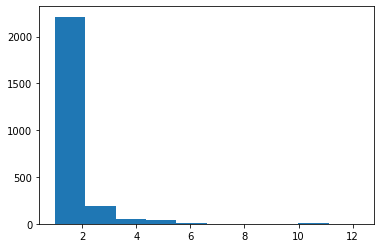

In [0]:
# plot submission 5 (score 0.746459)
plt.hist(sscore)
plt.show()

# 7. Conclusions

In [0]:
### 7.1. PCA

### 7.1. PCA


With this eigen value repartition, we have a better score by keeping 5 components (score: 0.637) than 10 (0.608) and 3 (0.631).

![PCA-eigenvalues](./images/PCA_components.png)

## 7.2. Results comparison

We will explore the submission we made. We take the one with the best score, submission 5 (0.746), and the one with the worst score, submission 3 (0.52).

The score repartition is better with the submission 5. We have a clear separation between the top scores and the others. The curve of the submission 3 is too smooth.

![Score repartition submission 5](./images/score-repartition-submission-5.png) 

![Score repartition submission 3](./images/score-repartition-submission-3.png) 

The time series with the highest scores seem more atypical for the submission 5 than submission 3. For instance, in the submission 3 there is no inclined curves compared to submission 5. It gives a good idea as the curves that must be classified as anomalies.

![Time series with the highest scores for submission 5](./images/submission-5.png) 

![Time series with the highest scores for submission 3](./images/submission-3.png) 